In [1]:
#!pip install backtrader

In [2]:
from datetime import datetime
import backtrader as bt
import matplotlib

matplotlib.__version__

'3.2.2'

In [3]:
cerebro = bt.Cerebro()

In [4]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        # To keep track of pending orders
        self.order = None

    def log(self, txt, dt=None):
        '''Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {order.executed.price}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {order.executed.price}')

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Reset order status to prepare for next order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'Close, {self.dataclose[0]}')

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                # current close less than previous close

                if self.dataclose[-1] < self.dataclose[-2]:
                    # previous close less than the previous close

                    # BUY, BUY, BUY!!! (with default parameters)
                    self.log(f'BUY CREATE, self.dataclose[0]')

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()

        else:
            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log(f'SELL CREATE, {self.dataclose[0]}')

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [5]:
# Add a strategy
cerebro.addstrategy(TestStrategy)

0

In [6]:
data = bt.feeds.YahooFinanceData(dataname='^NSEI', fromdate=datetime(2020, 1, 1),
                                  todate=datetime(2021, 2, 16))
cerebro.adddata(data)

In [7]:
cerebro.broker.setcash(10_00_000.0)

In [8]:
# Set the commission - Rs 20 per transcation
cerebro.broker.setcommission(commission=20, margin=1_70_000)

In [9]:
starting = cerebro.broker.getvalue()
print(f'Starting Portfolio Value: {starting}')

Starting Portfolio Value: 1000000.0


In [10]:
%%time
cerebro.run()

2020-01-01, Close, 12182.5
2020-01-01, BUY CREATE, self.dataclose[0]
2020-01-02, BUY EXECUTED, 12198.55
2020-01-02, Close, 12282.2
2020-01-03, Close, 12226.65
2020-01-06, Close, 11993.05
2020-01-07, Close, 12052.95
2020-01-08, Close, 12025.35
2020-01-09, Close, 12215.9
2020-01-09, SELL CREATE, 12215.9
2020-01-10, SELL EXECUTED, 12271.0
2020-01-10, Close, 12256.8
2020-01-13, Close, 12329.55
2020-01-14, Close, 12362.3
2020-01-15, Close, 12343.3
2020-01-16, Close, 12355.5
2020-01-17, Close, 12352.35
2020-01-20, Close, 12224.55
2020-01-20, BUY CREATE, self.dataclose[0]
2020-01-21, BUY EXECUTED, 12195.3
2020-01-21, Close, 12169.85
2020-01-22, Close, 12106.9
2020-01-23, Close, 12180.35
2020-01-24, Close, 12248.25
2020-01-27, Close, 12119.0
2020-01-28, Close, 12055.8
2020-01-28, SELL CREATE, 12055.8
2020-01-29, SELL EXECUTED, 12114.9
2020-01-29, Close, 12129.5
2020-01-30, Close, 12035.8
2020-01-31, Close, 11962.1
2020-01-31, BUY CREATE, self.dataclose[0]
2020-02-03, BUY EXECUTED, 11627.45
202

In [11]:
ending = cerebro.broker.getvalue()
print(f'Final Portfolio Value: {ending}')

Final Portfolio Value: 999766.6500000003


In [12]:
print(f'Returns: {round(((ending - starting)/starting)*100, 2)}%')

Returns: -0.02%


<IPython.core.display.Javascript object>


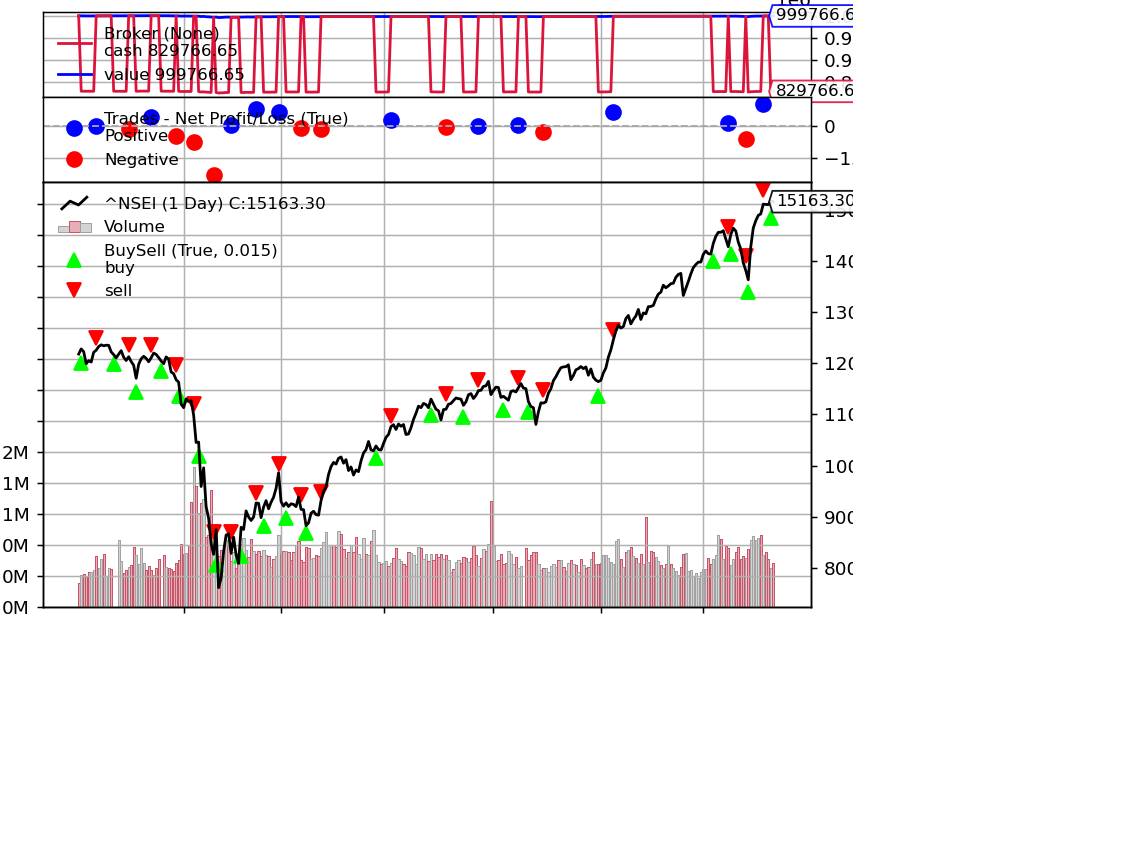

[[<Figure size 640x480 with 4 Axes>]]

In [13]:
cerebro.plot()